In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
#from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

device = torch.device('cuda')

In [3]:
tokenizer = AutoTokenizer.from_pretrained('ReynaQuita/twitter_disaster_bert_large')
bert = AutoModel.from_pretrained('ReynaQuita/twitter_disaster_bert_large')
'''inputs = tokenizer("I'm using TwHIN-BERT! #TwHIN-BERT #NLP", return_tensors="pt")
outputs = model(**inputs)'''

tokenizer_config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'inputs = tokenizer("I\'m using TwHIN-BERT! #TwHIN-BERT #NLP", return_tensors="pt")\noutputs = model(**inputs)'

In [10]:
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [11]:
train_df = pd.read_csv('/content/train.csv')
sample = pd.read_csv('/content/sample_submission.csv')

In [12]:
train_df.loc[(train_df.keyword.isna()==False)]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [13]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [14]:
X = train_df['text'].astype('str')
y = train_df['target']
train_text, test_text, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=1)
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.25, random_state=1)

<Axes: >

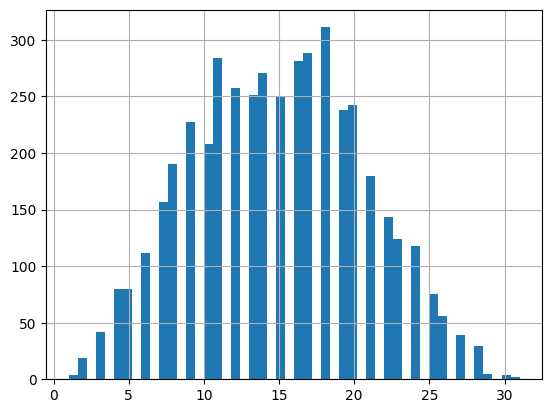

In [15]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [16]:
train_text = list(train_text)
test_text = list(test_text)
val_text = list(val_text)

In [17]:
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 25,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = 25,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 25,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [27]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.bert.config.hidden_size,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [28]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_weights)

[0.8847346  1.14979859]


In [30]:
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 20

In [31]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [32]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, total_preds

In [33]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20


100%|██████████| 191/191 [00:09<00:00, 19.96it/s]



Training loss: 0.373
Validation loss: 0.374

 Epoch2 / 20


100%|██████████| 191/191 [00:10<00:00, 18.70it/s]



Training loss: 0.354
Validation loss: 0.375

 Epoch3 / 20


100%|██████████| 191/191 [00:09<00:00, 19.95it/s]



Training loss: 0.346
Validation loss: 0.388

 Epoch4 / 20


100%|██████████| 191/191 [00:09<00:00, 19.95it/s]



Training loss: 0.341
Validation loss: 0.375

 Epoch5 / 20


100%|██████████| 191/191 [00:09<00:00, 20.21it/s]



Training loss: 0.343
Validation loss: 0.367

 Epoch6 / 20


100%|██████████| 191/191 [00:09<00:00, 19.45it/s]



Training loss: 0.337
Validation loss: 0.353

 Epoch7 / 20


100%|██████████| 191/191 [00:09<00:00, 19.40it/s]



Training loss: 0.335
Validation loss: 0.381

 Epoch8 / 20


100%|██████████| 191/191 [00:09<00:00, 20.38it/s]



Training loss: 0.334
Validation loss: 0.375

 Epoch9 / 20


100%|██████████| 191/191 [00:09<00:00, 19.87it/s]



Training loss: 0.335
Validation loss: 0.362

 Epoch10 / 20


100%|██████████| 191/191 [00:10<00:00, 18.66it/s]



Training loss: 0.327
Validation loss: 0.377

 Epoch11 / 20


100%|██████████| 191/191 [00:09<00:00, 20.16it/s]



Training loss: 0.337
Validation loss: 0.370

 Epoch12 / 20


100%|██████████| 191/191 [00:09<00:00, 20.13it/s]



Training loss: 0.330
Validation loss: 0.381

 Epoch13 / 20


100%|██████████| 191/191 [00:09<00:00, 20.05it/s]



Training loss: 0.331
Validation loss: 0.361

 Epoch14 / 20


100%|██████████| 191/191 [00:09<00:00, 20.15it/s]



Training loss: 0.330
Validation loss: 0.364

 Epoch15 / 20


100%|██████████| 191/191 [00:09<00:00, 20.18it/s]



Training loss: 0.331
Validation loss: 0.364

 Epoch16 / 20


100%|██████████| 191/191 [00:09<00:00, 20.13it/s]



Training loss: 0.328
Validation loss: 0.379

 Epoch17 / 20


100%|██████████| 191/191 [00:09<00:00, 20.07it/s]



Training loss: 0.337
Validation loss: 0.364

 Epoch18 / 20


100%|██████████| 191/191 [00:09<00:00, 20.08it/s]



Training loss: 0.328
Validation loss: 0.378

 Epoch19 / 20


100%|██████████| 191/191 [00:09<00:00, 20.14it/s]



Training loss: 0.333
Validation loss: 0.365

 Epoch20 / 20


100%|██████████| 191/191 [00:09<00:00, 20.11it/s]


Training loss: 0.331
Validation loss: 0.362


In [34]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 25)
list_mask = np.array_split(test_mask, 25)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [36]:
test_labels = list(test_labels)

In [37]:
test_df = pd.concat([pd.Series(test_text), pd.Series(test_labels)], axis = 1)

In [38]:
test_df = test_df.rename(columns = {0:'text', 1:'target'})

In [39]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

In [40]:
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.92 else 0)

print(classification_report(test_df['target'], test_df['pred']))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       882
           1       0.93      0.80      0.86       641

    accuracy                           0.89      1523
   macro avg       0.90      0.88      0.88      1523
weighted avg       0.89      0.89      0.89      1523



In [41]:
test = pd.read_csv('/content/test.csv')

In [42]:
test_text = test['text']
tokens_test = tokenizer.batch_encode_plus(
    list(test_text),
    max_length = 25,
    padding = 'max_length',
    truncation = True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 25)
list_mask = np.array_split(test_mask, 25)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [44]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test['confidence'] = flat_preds

In [45]:
test['target'] = test['confidence'].apply(lambda x: 1 if x>0.92 else 0)

In [46]:
test.head()

,id,keyword,location,text,confidence,target
0,0,NaN,NaN,Just happened a terrible car crash,0.996493,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.998159,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.998184,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.999965,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.999989,1


In [47]:
ans = pd.concat([test.id, test.target], axis=1).rename({0:'id', 1:'target'})

In [48]:
ans

,id,target
id,0,1
target,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [49]:
ans.to_csv('ans.csv', index = False)